In [1]:
import os
os.sys.path.append("C:\\Users\mplitt\MightyMorphingPhotonRangers")
import numpy as np
import matplotlib.pyplot as plt
import utilities as u
import preprocessing as pp
import behavior as b
import SimilarityMatrixAnalysis as sm
import scipy as sp
import PlaceCellAnalysis as pc
import matplotlib.gridspec as gridspec
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression as linreg

from scipy.interpolate import interp1d as spline

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
rare = ['4139265.3','4139265.4','4139265.5','4139268.1']
freq = ['4222153.1','4222153.2','4222153.3','4222174.1','4222154.1']

In [3]:
df = pp.load_session_db()
df = df[df['RewardCount']>30]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])
tracks = 'TwoTower_foraging'
df = df[df['Track'].str.contains(tracks,regex=True)]

G:\My Drive\VR_Data\TwoTower\behavior.sqlite
G:\My Drive\VR_Data\TwoTower\4222174.0\30_05_2019\RuningTraining_1.sqlite
file doesn't exist, errors to come!!!
G:\My Drive\VR_Data\TwoTower\4222168.1\09_08_2019\RuningTraining_1.sqlite
file doesn't exist, errors to come!!!
G:\My Drive\VR_Data\TwoTower\4222169.2\26_08_2019\TwoTower_Timeout_0.sqlite
file doesn't exist, errors to come!!!


In [14]:
df_mouse = df[df['MouseName']=='4139265.5']
df_mouse

,MouseName,DateFolder,SessionNumber,Track,RewardCount,Imaging,ImagingRegion,DateTime,data file,scanfile,scanmat,s2pfolder
1410,4139265.5,10_02_2019,1,TwoTower_foraging,60,1,CA1,2019-02-10,G:\My Drive\VR_Data\TwoTower\4139265.5\10_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.5\10_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.5\10_02_2...
1412,4139265.5,10_02_2019,3,TwoTower_foraging,60,1,CA1,2019-02-10,G:\My Drive\VR_Data\TwoTower\4139265.5\10_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.5\10_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.5\10_02_2...
1425,4139265.5,11_02_2019,1,TwoTower_foraging,150,0,,2019-02-11,G:\My Drive\VR_Data\TwoTower\4139265.5\11_02_2...,None,None,None
1439,4139265.5,12_02_2019,2,TwoTower_foraging,90,1,CA1,2019-02-12,G:\My Drive\VR_Data\TwoTower\4139265.5\12_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.5\12_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.5\12_02_2...
1440,4139265.5,12_02_2019,3,TwoTower_foraging,60,0,,2019-02-12,G:\My Drive\VR_Data\TwoTower\4139265.5\12_02_2...,None,None,None
1443,4139265.5,14_02_2019,2,TwoTower_foraging,175,0,,2019-02-14,G:\My Drive\VR_Data\TwoTower\4139265.5\14_02_2...,None,None,None
1462,4139265.5,15_02_2019,2,TwoTower_foraging,86,1,CA1,2019-02-15,G:\My Drive\VR_Data\TwoTower\4139265.5\15_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.5\15_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.5\15_02_2...
1463,4139265.5,15_02_2019,3,TwoTower_foraging,60,0,CA1,2019-02-15,G:\My Drive\VR_Data\TwoTower\4139265.5\15_02_2...,None,None,None
1470,4139265.5,16_02_2019,1,TwoTower_foraging,175,0,,2019-02-16,G:\My Drive\VR_Data\TwoTower\4139265.5\16_02_2...,None,None,None
1481,4139265.5,17_02_2019,2,TwoTower_foraging,80,1,CA1,2019-02-17,G:\My Drive\VR_Data\TwoTower\4139265.5\17_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.5\17_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.5\17_02_2...


In [15]:
EM = []
for i in range(11):
    sess = df_mouse.iloc[i]
    VRDat = pp.behavior_dataframe(sess['data file'])
    trial_info, tstart_inds, teleport_inds = u.by_trial_info(VRDat)
    em = trial_info['morphs']+trial_info['wallJitter']+trial_info['bckgndJitter']+trial_info['towerJitter']
    em +=.3
    em /=1.6
    EM.extend(em.tolist())
#     N += len(trial_info['morphs'])
#     m += len(trial_info['morphs']) - (trial_info['morphs']==0).sum() - (trial_info['morphs']==1).sum()
    print(i)

0
1
2
3
4
5
6
7
8
9
10


In [16]:
h,edges = np.histogram(np.array(EM)*1.6-.3,bins=20)

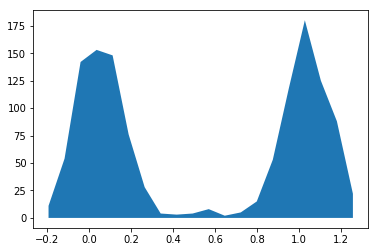

In [17]:
f,ax = plt.subplots()
ax.fill_between(edges[1:],h)